In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
#os.environ["SHALLOWWATER_USE_NUMBA"] = "0"  # if you want to disable numba
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          wind_gyre_forcing,run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# tiny arrays just to trigger compilation
try:
    from numba import njit, prange
    NUMBA_AVAILABLE = True
except Exception:
    NUMBA_AVAILABLE = False
    def njit(*args, **kwargs):
        def deco(f): return f
        return deco
    def prange(*args):
        return range(*args)

USE_NUMBA = os.getenv("SHALLOWWATER_USE_NUMBA", "0") == "1"

if USE_NUMBA and NUMBA_AVAILABLE:
    import numpy as np
    from shallowwater.operators import avg_u_to_center, avg_v_to_center
    u = np.zeros((8, 9)); v = np.zeros((9, 8))
    _ = avg_u_to_center(u); _ = avg_v_to_center(v)
else:
    print('not using numba')

not using numba


In [3]:
import math

def save_every_for_target_frames(tmax, dt, n_frames, include_initial=True):
    """
    Choose a save_every stride to produce about n_frames snapshots over [0, tmax].
    """
    if n_frames <= 1:
        # only initial (or final) frame
        return max(1, math.ceil(tmax/dt))  # save at start; plot just one frame
    N = math.ceil(tmax / dt)
    intervals = (n_frames - 1) if include_initial else n_frames
    return max(1, int(round(N / intervals)))


### Linear case

In [4]:
# Grid & params
Nx, Ny = 128, 128
Lx, Ly = 3.0e6, 3.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

# Just an example of how to set things, *no* code change required
params = ModelParams(
    H=500.0, g=.2, rho=1025.0,
    f0=1e-4, beta=2e-11, y0=Ly/2,
    r=3.0e-7,
    linear=True,
    Ah=500.0,
    Hmin_frac=0.02,
    qmax=5e-4,
)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 2 * 365 * 24 * 3600
save_every = save_every_for_target_frames(tmax, dt, n_frames=120)

ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")
forcing_fn = lambda t, g, p: wind_gyre_forcing(t, g, p, tau0=0.1)
 
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"),
                show_progress=True,
                progress_kwargs={"desc": "Linear wind gyre", "unit": "step"}
               )

print('Saved steps:', len(out['time']))

Linear wind gyre: 100%|███████████████| 53822/53822 [00:50<00:00, 1074.53step/s]

Saved steps: 121


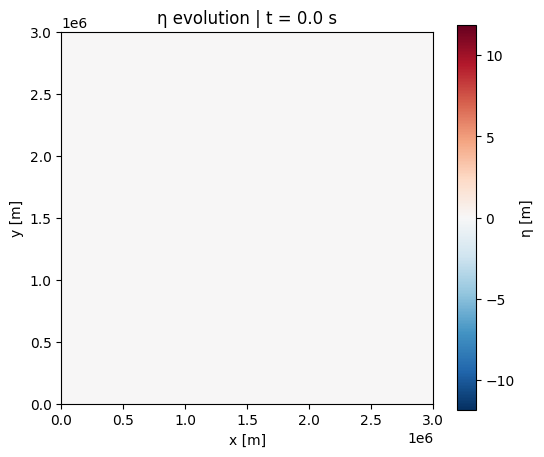

In [5]:
# Quick look animation (if you added visualize.py earlier)
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=120, title="η evolution")

# GIF (no external dependencies)
anim.save("eta_12.gif", fps=10)

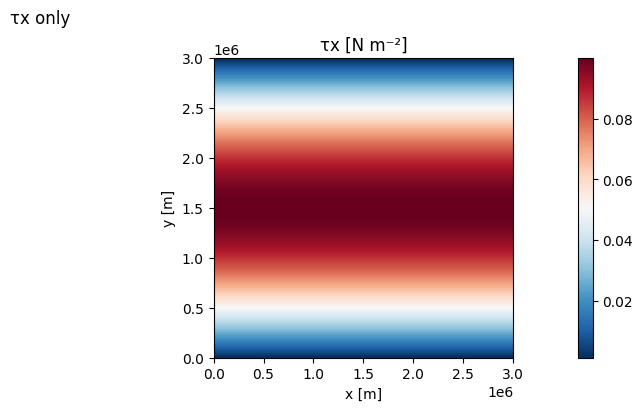

In [6]:
from shallowwater.visualize import plot_forcings

fig_tx = plot_forcings(forcing_fn, t=0.0, grid=grid, params=params, what="taux",
                       title="τx only")

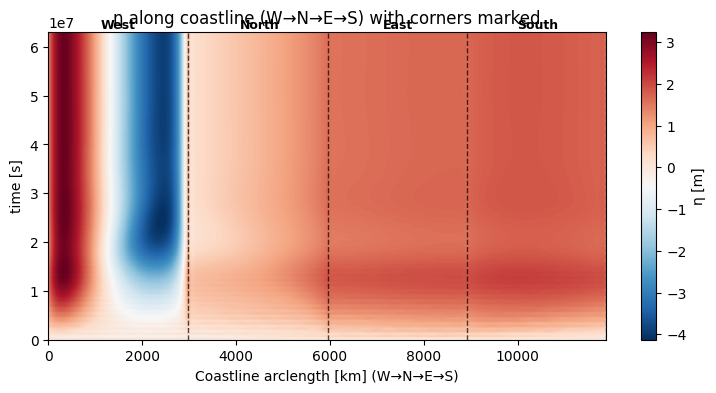

In [7]:
from shallowwater.visualize import coast_hovmoller

fig = coast_hovmoller(out, grid, units_x="km",
                      title="η along coastline (W→N→E→S) with corners marked")

### nonlinear case (momentum advection + lateral viscosity)

In [8]:
# Grid & params
Nx, Ny = 128, 128
Lx, Ly = 3.0e6, 3.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

# Just an example of how to set things, *no* code change required
params = ModelParams(
    H=500.0, g=.2, rho=1025.0,
    f0=1e-4, beta=2e-11, y0=Ly/2,
    r=3.0e-7,
    linear=False,
    Ah=500.0,
    Hmin_frac=0.02,
    qmax=5e-4,
)

dt = compute_dt_cfl(grid, params, cfl=0.25)
tmax = 2 * 365 * 24 * 3600
save_every = save_every_for_target_frames(tmax, dt, n_frames=120)

ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")
forcing_fn = lambda t, g, p: wind_gyre_forcing(t, g, p, tau0=0.1)
 
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"),
                show_progress=True,
                progress_kwargs={"desc": "Non Linear wind gyre", "unit": "step"}
               )

print('Saved steps:', len(out['time']))

Linear wind gyre: 100%|██████████████| 107643/107643 [03:00<00:00, 595.30step/s]

Saved steps: 120


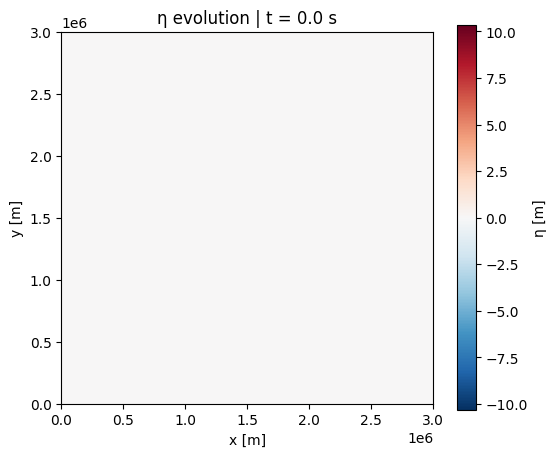

In [9]:
# Quick look animation (if you added visualize.py earlier)
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=120, title="η evolution")

# GIF (no external dependencies)
anim.save("eta_12b_nonlinear.gif", fps=10)